In [1]:
%load_ext autoreload

In [2]:
%autoreload # When utils.py is updated
from utils_unet_resunet import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
dm = 'yes'
n_dates = 7
root_path = 'Dados_SAR/'

#LOADING IMAGE SEQUENCE

name_img1 = 'img1_raw' 
name_img2 = 'img2_raw' 
name_img3 = 'PA_2019_10_08'
name_img4 = 'PA_2019_12_07'
name_img5 = 'PA_2020_02_05'
name_img6 = 'PA_2020_04_05'
name_img7 = 'PA_2020_06_04'

img1 = load_SAR_image(root_path+'SAR_Sequence/'+name_img1+'.tif').astype(np.float32) 
img1 = filter_outliers(img1.copy()) 
print('img1', np.min(img1), np.max(img1))
print('image1: ', img1.shape)

img2 = load_SAR_image(root_path+'SAR_Sequence/'+name_img2+'.tif').astype(np.float32) 
img2 = filter_outliers(img2.copy()) 
print('img2', np.min(img2), np.max(img2))
print('image2: ', img2.shape)

img3 = load_SAR_image(root_path+'SAR_Sequence/'+name_img3+'.tif').astype(np.float32) 
img3 = filter_outliers(img3.copy()) 
print('img3', np.min(img3), np.max(img3))
print('image3: ', img3.shape)

img4 = load_SAR_image(root_path+'SAR_Sequence/'+name_img4+'.tif').astype(np.float32) 
img4 = filter_outliers(img4.copy()) 
print('img4', np.min(img4), np.max(img4))
print('image4: ', img4.shape)

img5 = load_SAR_image(root_path+'SAR_Sequence/'+name_img5+'.tif').astype(np.float32) 
img5 = filter_outliers(img5.copy()) 
print('img5', np.min(img5), np.max(img5))
print('image5: ', img5.shape)

img6 = load_SAR_image(root_path+'SAR_Sequence/'+name_img6+'.tif').astype(np.float32) 
img6 = filter_outliers(img6.copy()) 
print('img6', np.min(img6), np.max(img6))
print('image6: ', img6.shape)

img7 = load_SAR_image(root_path+'SAR_Sequence/'+name_img7+'.tif').astype(np.float32) 
img7 = filter_outliers(img7.copy()) 
print('img7', np.min(img7), np.max(img7))
print('image7: ', img7.shape)

Dados_SAR/SAR_Sequence/img1_raw.tif
img1 0.01 0.87
image1:  (5767, 9327, 2)
Dados_SAR/SAR_Sequence/img2_raw.tif
img2 0.01 0.85
image2:  (5767, 9327, 2)
Dados_SAR/SAR_Sequence/PA_2019_10_08.tif
img3 -38.53 -1.28
image3:  (5767, 9327, 2)
Dados_SAR/SAR_Sequence/PA_2019_12_07.tif
img4 -38.3 -1.06
image4:  (5767, 9327, 2)
Dados_SAR/SAR_Sequence/PA_2020_02_05.tif
img5 -31.94 -0.97
image5:  (5767, 9327, 2)
Dados_SAR/SAR_Sequence/PA_2020_04_05.tif
img6 -31.91 -0.98
image6:  (5767, 9327, 2)
Dados_SAR/SAR_Sequence/PA_2020_06_04.tif
img7 -31.67 -0.39
image7:  (5767, 9327, 2)


In [4]:
# Load current reference 
ref_2020 = 'def_2020' 
ref_2020 = load_tif_image(root_path+'References/'+ref_2020+'.tif').astype(np.float32)

# Load past reference 
past_ref_2019 = 'def_2008_2019' 
past_ref_2019 = load_tif_image(root_path+'References/'+past_ref_2019+'.tif').astype(np.float32)

past_ref_2007 = 'def_1988_2007'
past_ref_2007 = load_tif_image(root_path+'References/'+past_ref_2007+'.tif').astype(np.float32)

past_ref = past_ref_2019 + past_ref_2007 
past_ref[past_ref >=1 ] = 1
np.unique(past_ref)
buffer = 2
final_mask1 = mask_no_considered(ref_2020, buffer, past_ref)
del past_ref_2019, past_ref_2007
print(final_mask1.shape)


Dados_SAR/References/def_2020.tif
Dados_SAR/References/def_2008_2019.tif
Dados_SAR/References/def_1988_2007.tif
(5767, 9327)


In [5]:
# Print percentage of each class (whole image)
no_def = len(final_mask1[final_mask1==0])
def_ = len(final_mask1[final_mask1==1])
pt_def = len(final_mask1[final_mask1==2])
print('Percentage of deforestaion class is {:.2f}'.format((def_*100)/(final_mask1.shape[0]*final_mask1.shape[1])))
print('Percentage of no-deforestaion class is {:.2f}'.format((no_def*100)/(final_mask1.shape[0]*final_mask1.shape[1])))
print('Percentage of past-deforestaion class is {:.2f}'.format((pt_def*100)/(final_mask1.shape[0]*final_mask1.shape[1])))

Percentage of deforestaion class is 1.06
Percentage of no-deforestaion class is 64.89
Percentage of past-deforestaion class is 34.04


In [6]:
image_array1 = np.concatenate((img1, img2, img3, img4, img5, img6, img7), axis = -1).astype(np.float32)
del img1, img2, img3, img4, img5, img6, img7

h_, w_, channels = image_array1.shape
print(image_array1.shape)

# Normalization
type_norm = 1
image_array = normalization(image_array1, type_norm)

print(np.min(image_array), np.max(image_array))

(5767, 9327, 14)
-6.8049436 5.7555103


In [7]:
tiles_x = 6
tiles_y = 10
mask_tiles = create_mask(final_mask1.shape[0], final_mask1.shape[1], grid_size=(tiles_x,tiles_y))
image_array = image_array[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
final_mask1 = final_mask1[:mask_tiles.shape[0], :mask_tiles.shape[1]]
ref_2020 = ref_2020[:mask_tiles.shape[0], :mask_tiles.shape[1]]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_array.shape)
print('ref :', final_mask1.shape)

Tiles size:  961 932
Mask size:  (5766, 9320)
mask:  (5766, 9320)
image stack:  (5766, 9320, 14)
ref : (5766, 9320)


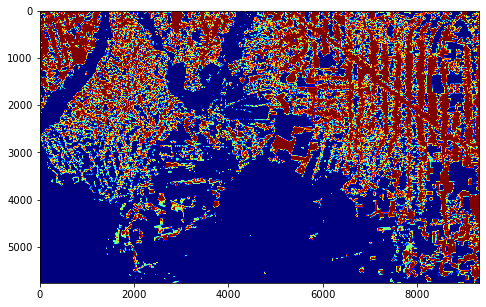

In [8]:
import matplotlib
plt.figure(figsize=(20,10))
plt.imshow(final_mask1, cmap = matplotlib.colors.ListedColormap(['darkblue','darkred','darkgrey']))
plt.axis('off')

In [8]:
exp = 1
path_exp = root_path+'experiments/exp'+str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)

In [10]:
#BATCH GENERATOR _ RUN WHEN USING RESUNET
def batch_generator(batches, image, reference, target_size, number_class):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    image = image.reshape(-1, image.shape[-1])
    reference = reference.reshape(final_mask1.shape[0]*final_mask1.shape[1])
    while True:
        batch_x, batch_y = next(batches)
        batch_x = np.squeeze(batch_x.astype('int64'))
        #print(batch_x.shape)
        batch_img = np.zeros((batch_x.shape[0], target_size, target_size, image.shape[-1]))
        batch_ref = np.zeros((batch_x.shape[0], target_size, target_size, number_class))
        
        for i in range(batch_x.shape[0]):
            if np.random.rand()>0.5:
                batch_x[i] = np.rot90(batch_x[i], 1)
            batch_img[i] = image[batch_x[i]] 
            batch_ref[i] = tf.keras.utils.to_categorical(reference[batch_x[i]] , number_class)
                       
        yield (batch_img, batch_ref)
#end batch_gener

In [11]:
weights = [0.2, 0.8, 0]
overlap = 0.7
patch_size = 128
batch_size = 32
im_idx = create_idx_image(final_mask1)
patches_idx = extract_patches(im_idx, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1,patch_size, patch_size)
del im_idx

In [12]:
# Define model

number_class = 3
nb_filters = [32, 64, 128]
adam = Adam(learning_rate = 1e-3 , beta_1=0.9)
loss = weighted_categorical_crossentropy(weights)
input_shape = (patch_size, patch_size, channels)

n_dates = 7
f1 =32

method = 'resunet'

if method == 'resunet':
   model = build_resunet(input_shape, nb_filters, number_class)

if method == 'ulstm':
    channels = 2
    model = U_ConvLSTM(n_dates, patch_size, patch_size, channels, number_class, f1) 

set:  0
Number of training patches:   3288 Number of validation patches 1048
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_enc_net (InputLayer)     [(None, 128, 128, 1  0           []                               
                                4)]                                                               
                                                                                                  
 res1_net1 (Conv2D)             (None, 128, 128, 32  4064        ['input_enc_net[0][0]']          
                                )                                                                 
                                                                                                  
 drop_net1 (Dropout)            (None, 128, 128, 32  0           ['res1_net1[0][0]']              
                 

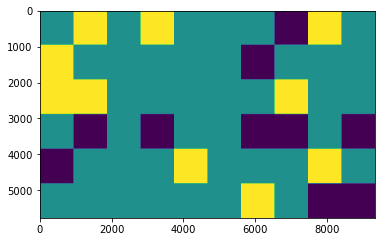

In [15]:
time_tr = []
kfold = 6  
for tm in range(0,kfold):
    print('set: ', tm)
    
    mask_tr_val = np.load(root_path+'Distribution/mask_dist_'+str(tm)+'.npy')
    plt.imshow(mask_tr_val)
    patches_mask = extract_patches(mask_tr_val, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1, patch_size, patch_size)
    
    # Selecting index trn val and test patches idx
    idx_trn = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==patch_size**2))
    idx_val = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==2*patch_size**2))
    del patches_mask

    patches_idx_trn = patches_idx[idx_trn]
    patches_idx_val = patches_idx[idx_val]
    del idx_trn, idx_val
    
    # Extract patches with at least 2% of deforestation class
    X_train = retrieve_idx_percentage(final_mask1, patches_idx_trn, patch_size, 2)
    X_valid = retrieve_idx_percentage(final_mask1, patches_idx_val, patch_size, 2)
    #print(X_train.shape, X_valid.shape)
    print('Number of training patches:  ', len(X_train), 'Number of validation patches', len(X_valid))
    del patches_idx_trn, patches_idx_val
    
    train_datagen = ImageDataGenerator(horizontal_flip = True,
                                       vertical_flip = True)
    valid_datagen = ImageDataGenerator(horizontal_flip = True, 
                                       vertical_flip = True)

    y_train = np.zeros((len(X_train)))
    y_valid = np.zeros((len(X_valid)))

    train_gen = train_datagen.flow(np.expand_dims(X_train, axis = -1), y_train,
                                  batch_size=batch_size,
                                  shuffle=True)

    valid_gen = valid_datagen.flow(np.expand_dims(X_valid, axis = -1), y_valid,
                                  batch_size=batch_size,
                                  shuffle=False)
    
    train_gen_crops = batch_generator(train_gen, image_array, final_mask1, patch_size, number_class)
    valid_gen_crops = batch_generator(valid_gen, image_array, final_mask1, patch_size, number_class)
    
    #model = build_resunet(input_shape, nb_filters, number_class)
    model_i = model
    model_i.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
    model_i.summary()

    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
    checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
    callbacks_list = [earlystop, checkpoint]
    # train the model
    start_training = time.time()
    history = model_i.fit(train_gen_crops,
                        steps_per_epoch=len(X_train)*3//train_gen.batch_size,
                        validation_data=valid_gen_crops,
                        validation_steps=len(X_valid)*3//valid_gen.batch_size,
                        epochs=100,
                        callbacks=callbacks_list)
    end_training = time.time() - start_training
    time_tr.append(end_training)
    del model_i, train_gen, valid_gen, train_gen_crops, valid_gen_crops, mask_tr_val
    
time_tr_array = np.asarray(time_tr)
# Save training time
np.save(path_exp+'/metrics_tr.npy', time_tr_array)

In [18]:
# Test loop
time_ts = []
n_pool = 3
n_rows = 6
n_cols = 10
rows, cols = image_array.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_array, pad_width=npad, mode='reflect')

h, w, c = image1_pad.shape
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

input_shape=(patch_size_rows,patch_size_cols, c)

if method == 'resunet':
   new_model = build_resunet(input_shape, nb_filters, number_class)

for tm in range(0,kfold):
    print('time: ', tm)
    model = load_model(path_models+ '/' + method +'_'+str(tm)+'.h5', compile=False)

    for l in range(1, len(model.layers)):
        new_model.layers[l].set_weights(model.layers[l].get_weights())

    start_test = time.time()
    patch_t = []

    for i in range(0,num_patches_y):
        for j in range(0,num_patches_x):
            patch = image1_pad[patch_size_rows*j:patch_size_rows*(j+1), patch_size_cols*i:patch_size_cols*(i+1), :]
            predictions_ = new_model.predict(np.expand_dims(patch, axis=0))
            del patch 
            patch_t.append(predictions_[:,:,:,1])
            del predictions_
    end_test =  time.time() - start_test
    patches_pred = np.asarray(patch_t).astype(np.float32)

    prob_recontructed = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred)
    np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_recontructed) 

    time_ts.append(end_test)
    del model, patches_pred
time_ts_array = np.asarray(time_ts)
# Save test time
np.save(path_exp+'/metrics_ts.npy', time_ts_array)    
del image_array, image1_pad

-42.0 -40.0
time:  0
1/1 [==============================] - 0s 63ms/step
time:  1
1/1 [==============================] - 0s 71ms/step
time:  2
1/1 [==============================] - 0s 56ms/step
time:  3
1/1 [==============================] - 0s 73ms/step
time:  4
1/1 [==============================] - 0s 44ms/step
time:  5
1/1 [==============================] - 0s 61ms/step


In [19]:
prob_rec = np.zeros((final_mask1.shape[0], final_mask1.shape[1], kfold))
for tm in range (0, kfold):
    print(tm)
    prob_map = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)
    prob_map = prob_map[:final_mask1.shape[0], :final_mask1.shape[1]]
    mask_tr_val = np.load(root_path+'Distribution/mask_dist_'+str(tm)+'.npy')
    mask_amazon_ts = mask_tr_val.copy()
    mask_amazon_ts[mask_amazon_ts >= 1] = 2
    mask_amazon_ts[mask_amazon_ts == 0] = 1
    mask_amazon_ts[mask_amazon_ts == 2] = 0

    prob_rec[:,:,tm] = prob_map * mask_amazon_ts
    #plt.imshow(prob_test, cmap = 'jet')
    #np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_test) 

prob_sum = np.sum(prob_rec, axis = -1)
np.save(path_maps+'/prob_sum.npy', prob_sum)

0
1
2
3
4
5


In [ ]:
"""
OUTPUT MAP

no-deforestation (true negatives) =  darkblue
deforestation (true positives) = darkred
false positives = yellow
false negatives = cyan
past deforestation = darkgrey

"""
threshold = 0.5
outmap = color_map(prob_sum, ref_2020, final_mask1, threshold)
plt.figure(figsize=(20,10))
plt.imshow(outmap, cmap = matplotlib.colors.ListedColormap(['darkblue','darkred','yellow','c','darkgrey']))
plt.axis('off')



In [11]:
#Calculate metrics
prob_sum = np.load(path_maps+'/prob_sum.npy')
ref1 = np.ones_like(final_mask1).astype(np.float32)

ref1 [final_mask1 == 2] = 0
TileMask = np.ones_like(final_mask1).astype(np.float32)

#threshold = 0.5
metricss = matrics_AA_recall([0.5], prob_sum, final_mask1, TileMask, 156)
# Complete NaN values
metrics_copy_ = metricss.copy()
metrics_copy_ = complete_nan_values(metrics_copy_)

Recall_ = metrics_copy_[:,0]
Precision_ = metrics_copy_[:,1]
F1_Score = metrics_copy_[:,2]

print("Recall = ", Recall_)
print("Precision = ", Precision_)
print("F1 Score = ", F1_Score)


0.5
Recall =  [0.5301178]
Precision =  [0.97072548]
F1 Score =  [0.68574629]
